<a href="https://colab.research.google.com/github/arthursl12/POC1/blob/main/POC1_Turbofan.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Imports

In [1]:
# %pip install sktime tsfresh;

In [2]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import glob

In [5]:
# import sktime

In [ ]:
sns.set_palette('colorblind')

# Dataset Download

In [6]:
!git clone https://github.com/arthursl12/dataset_2
!mv /content/dataset_2/CMaps /content/CMaps
!rm -rf dataset_2

Cloning into 'dataset_2'...
remote: Enumerating objects: 18, done.
remote: Counting objects: 100% (18/18), done.
remote: Compressing objects: 100% (17/17), done.
remote: Total 18 (delta 2), reused 0 (delta 0), pack-reused 0
Unpacking objects: 100% (18/18), done.


In [7]:
folder='/content/CMaps/'

# Data Integration

The data are provided as a zip-compressed text file with 26 columns of numbers, separated by spaces. Each row is a snapshot of data taken during a single operational cycle, each column is a different variable. The columns correspond to:  

1) unit number   
2) time, in cycles  
3) operational setting 1  
4) operational setting 2  
5) operational setting 3    
6) sensor measurement 1    
7) sensor measurement 2  
...  
26) sensor measurement 20


There are 6 conditions (or combinations) which the 3 operational settings can take.  
Condition 1: Altitude = 0, Mach Number = 0, TRA = 100  
Condition 2: Altitude = 10, Mach Number = 0.25, TRA = 100  
Condition 3: Altitude = 20, Mach Number = 0.7 TRA = 100  
Condition 4: Altitude = 25, Mach Number = 0.62, TRA = 60  
Condition 5: Altitude = 35 Mach Number = 0.84, TRA = 100  
Condition 6: Altitude = 42, Mach Number = 0.84, TRA = 100  
  
There is slight variation in all these conditions so you may get numbers like 24.453 instead of 25 exactly.

FD001: Condition 1 only  
FD002: Mix of all the conditions  
FD003: Condition 1 only  
FD004: Mix of all conditions  


In [8]:
# Column names
index_cols = ['unit_number', 'time']
settings_cols = ['op_1', 'op_2', 'op_3']
sensors_cols = [f's_{i}'for i in range(21)]
cols = index_cols + settings_cols + sensors_cols

In [9]:
train = pd.read_csv((folder+'train_FD001.txt'), sep='\s+', header=None, names=cols)
test = pd.read_csv((folder+'test_FD001.txt'), sep='\s+', header=None, names=cols)
y_test = pd.read_csv((folder+'RUL_FD001.txt'), sep='\s+', header=None, names=['RUL'])

In [10]:
train

,unit_number,time,op_1,op_2,op_3,s_0,s_1,s_2,s_3,s_4,...,s_11,s_12,s_13,s_14,s_15,s_16,s_17,s_18,s_19,s_20
0,1,1,-0.0007,-0.0004,100.0,518.67,641.82,1589.70,1400.60,14.62,...,521.66,2388.02,8138.62,8.4195,0.03,392,2388,100.0,39.06,23.4190
1,1,2,0.0019,-0.0003,100.0,518.67,642.15,1591.82,1403.14,14.62,...,522.28,2388.07,8131.49,8.4318,0.03,392,2388,100.0,39.00,23.4236
2,1,3,-0.0043,0.0003,100.0,518.67,642.35,1587.99,1404.20,14.62,...,522.42,2388.03,8133.23,8.4178,0.03,390,2388,100.0,38.95,23.3442
3,1,4,0.0007,0.0000,100.0,518.67,642.35,1582.79,1401.87,14.62,...,522.86,2388.08,8133.83,8.3682,0.03,392,2388,100.0,38.88,23.3739
4,1,5,-0.0019,-0.0002,100.0,518.67,642.37,1582.85,1406.22,14.62,...,522.19,2388.04,8133.80,8.4294,0.03,393,2388,100.0,38.90,23.4044
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20626,100,196,-0.0004,-0.0003,100.0,518.67,643.49,1597.98,1428.63,14.62,...,519.49,2388.26,8137.60,8.4956,0.03,397,2388,100.0,38.49,22.9735
20627,100,197,-0.0016,-0.0005,100.0,518.67,643.54,1604.50,1433.58,14.62,...,519.68,2388.22,8136.50,8.5139,0.03,395,2388,100.0,38.30,23.1594
20628,100,198,0.0004,0.0000,100.0,518.67,643.42,1602.46,1428.18,14.62,...,520.01,2388.24,8141.05,8.5646,0.03,398,2388,100.0,38.44,22.9333
20629,100,199,-0.0011,0.0003,100.0,518.67,643.23,1605.26,1426.53,14.62,...,519.67,2388.23,8139.29,8.5389,0.03,395,2388,100.0,38.29,23.0640


# Data Processing

## Test Set 
Test set has samples for all cycles, but has annotations only for last one

In [11]:
test

,unit_number,time,op_1,op_2,op_3,s_0,s_1,s_2,s_3,s_4,...,s_11,s_12,s_13,s_14,s_15,s_16,s_17,s_18,s_19,s_20
0,1,1,0.0023,0.0003,100.0,518.67,643.02,1585.29,1398.21,14.62,...,521.72,2388.03,8125.55,8.4052,0.03,392,2388,100.0,38.86,23.3735
1,1,2,-0.0027,-0.0003,100.0,518.67,641.71,1588.45,1395.42,14.62,...,522.16,2388.06,8139.62,8.3803,0.03,393,2388,100.0,39.02,23.3916
2,1,3,0.0003,0.0001,100.0,518.67,642.46,1586.94,1401.34,14.62,...,521.97,2388.03,8130.10,8.4441,0.03,393,2388,100.0,39.08,23.4166
3,1,4,0.0042,0.0000,100.0,518.67,642.44,1584.12,1406.42,14.62,...,521.38,2388.05,8132.90,8.3917,0.03,391,2388,100.0,39.00,23.3737
4,1,5,0.0014,0.0000,100.0,518.67,642.51,1587.19,1401.92,14.62,...,522.15,2388.03,8129.54,8.4031,0.03,390,2388,100.0,38.99,23.4130
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13091,100,194,0.0049,0.0000,100.0,518.67,643.24,1599.45,1415.79,14.62,...,520.69,2388.00,8213.28,8.4715,0.03,394,2388,100.0,38.65,23.1974
13092,100,195,-0.0011,-0.0001,100.0,518.67,643.22,1595.69,1422.05,14.62,...,521.05,2388.09,8210.85,8.4512,0.03,395,2388,100.0,38.57,23.2771
13093,100,196,-0.0006,-0.0003,100.0,518.67,643.44,1593.15,1406.82,14.62,...,521.18,2388.04,8217.24,8.4569,0.03,395,2388,100.0,38.62,23.2051
13094,100,197,-0.0038,0.0001,100.0,518.67,643.26,1594.99,1419.36,14.62,...,521.33,2388.08,8220.48,8.4711,0.03,395,2388,100.0,38.66,23.2699


In [12]:
y_test.count()

RUL    100
dtype: int64

In [13]:
# Let's take only the last line for each test set
test1 = test.groupby('unit_number').last().reset_index()
test1

,unit_number,time,op_1,op_2,op_3,s_0,s_1,s_2,s_3,s_4,...,s_11,s_12,s_13,s_14,s_15,s_16,s_17,s_18,s_19,s_20
0,1,31,-0.0006,0.0004,100.0,518.67,642.58,1581.22,1398.91,14.62,...,521.79,2388.06,8130.11,8.4024,0.03,393,2388,100.0,38.81,23.3552
1,2,49,0.0018,-0.0001,100.0,518.67,642.55,1586.59,1410.83,14.62,...,521.74,2388.09,8126.90,8.4505,0.03,391,2388,100.0,38.81,23.2618
2,3,126,-0.0016,0.0004,100.0,518.67,642.88,1589.75,1418.89,14.62,...,520.83,2388.14,8131.46,8.4119,0.03,395,2388,100.0,38.93,23.2740
3,4,106,0.0012,0.0004,100.0,518.67,642.78,1594.53,1406.88,14.62,...,521.88,2388.11,8133.64,8.4634,0.03,395,2388,100.0,38.58,23.2581
4,5,98,-0.0013,-0.0004,100.0,518.67,642.27,1589.94,1419.36,14.62,...,521.00,2388.15,8125.74,8.4362,0.03,394,2388,100.0,38.75,23.4117
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,96,97,-0.0006,0.0003,100.0,518.67,642.30,1590.88,1397.94,14.62,...,522.30,2388.01,8148.24,8.4110,0.03,391,2388,100.0,38.96,23.4606
96,97,134,0.0013,-0.0001,100.0,518.67,642.59,1582.96,1410.92,14.62,...,521.58,2388.06,8155.48,8.4500,0.03,395,2388,100.0,38.61,23.2953
97,98,121,0.0017,0.0001,100.0,518.67,642.68,1599.51,1415.47,14.62,...,521.53,2388.09,8146.39,8.4235,0.03,394,2388,100.0,38.76,23.3608
98,99,97,0.0047,-0.0000,100.0,518.67,642.00,1585.03,1397.98,14.62,...,521.82,2388.02,8150.38,8.4003,0.03,391,2388,100.0,38.95,23.3595


# Remaining Useful Life (RUL)

In [17]:
# RUL: how many cycles remain ? 
#   Take the last (maximun) cycle registered ('time' column) for that sample
#   Subtract from current cycle number
#   i.e. assume linear RUL decay
def add_remaining_useful_life_linear(df):
    # Get the total number of cycles for each unit
    grouped_by_unit = df.groupby(by="unit_number")
    max_cycle = grouped_by_unit["time"].max()
    
    # Merge the max cycle back into the original frame
    result_frame = df.merge(max_cycle.to_frame(name='max_cycle'), left_on='unit_number', right_index=True)
    
    # Calculate remaining useful life for each row
    remaining_useful_life = result_frame["max_cycle"] - result_frame["time"]
    result_frame["RUL"] = remaining_useful_life
    
    # drop max_cycle as it's no longer needed
    result_frame = result_frame.drop("max_cycle", axis=1)
    return result_frame
  
train = add_remaining_useful_life_linear(train)
train[index_cols+['RUL']].head()

,unit_number,time,RUL
0,1,1,191
1,1,2,190
2,1,3,189
3,1,4,188
4,1,5,187


# EDA

In [14]:
train[index_cols].groupby('unit_number').count().transpose()

unit_number,1,2,3,4,5,6,7,8,9,10,...,91,92,93,94,95,96,97,98,99,100
time,192,287,179,189,269,188,259,150,201,222,...,135,341,155,258,283,336,202,156,185,200


Cada amostra tem um tempo de término diferente, exatamente pois cada uma falhou em um tempo diferente

In [15]:
train[settings_cols].describe()

,op_1,op_2,op_3
count,20631.000000,20631.000000,20631.0
mean,-0.000009,0.000002,100.0
std,0.002187,0.000293,0.0
min,-0.008700,-0.000600,100.0
25%,-0.001500,-0.000200,100.0
50%,0.000000,0.000000,100.0
75%,0.001500,0.000300,100.0
max,0.008700,0.000600,100.0


No cenário FD001 só há uma condição, então é esperado que não haja muita variação nessas configurações.

In [16]:
train[sensors_cols].describe().transpose()

,count,mean,std,min,25%,50%,75%,max
s_0,20631.0,518.670000,6.537152e-11,518.6700,518.6700,518.6700,518.6700,518.6700
s_1,20631.0,642.680934,5.000533e-01,641.2100,642.3250,642.6400,643.0000,644.5300
s_2,20631.0,1590.523119,6.131150e+00,1571.0400,1586.2600,1590.1000,1594.3800,1616.9100
s_3,20631.0,1408.933782,9.000605e+00,1382.2500,1402.3600,1408.0400,1414.5550,1441.4900
s_4,20631.0,14.620000,3.394700e-12,14.6200,14.6200,14.6200,14.6200,14.6200
s_5,20631.0,21.609803,1.388985e-03,21.6000,21.6100,21.6100,21.6100,21.6100
s_6,20631.0,553.367711,8.850923e-01,549.8500,552.8100,553.4400,554.0100,556.0600
s_7,20631.0,2388.096652,7.098548e-02,2387.9000,2388.0500,2388.0900,2388.1400,2388.5600
s_8,20631.0,9065.242941,2.208288e+01,9021.7300,9053.1000,9060.6600,9069.4200,9244.5900
s_9,20631.0,1.300000,4.660829e-13,1.3000,1.3000,1.3000,1.3000,1.3000


Alguns sensores são constantes para esse cenário, eles não trarão informação para o modelo.

In [18]:
def sample_list_index(n_frac, df=train, unit_col='unit_number'):
    numbers = pd.DataFrame(df.groupby(unit_col).nunique().index)
    n = round(n_frac * len(numbers))
    numbers_sample = numbers.sample()[unit_col]
    nums = list(numbers.sample(n, random_state=42)[unit_col])
    return nums
sample_list_index(0.2)

[84, 54, 71, 46, 45, 40, 23, 81, 11, 1, 19, 31, 74, 34, 91, 5, 77, 78, 13, 32]

In [19]:
def plot_sensor_i(i,df=train,n_frac=0.1,unit_col='unit_number',time_col='time'):
    sensor_col = f's_{i}'
    indexes = sample_list_index(n_frac)
    plt.title(f"Sensor {i}")
    for k in indexes:
        df1 = df[df[unit_col] == k][[time_col,sensor_col]]
        df1 = df1.set_index(time_col)
        plt.plot(df1)

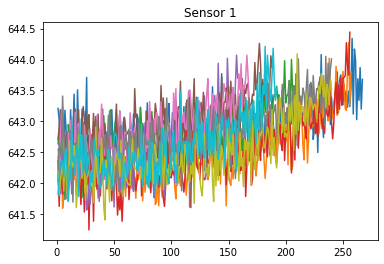

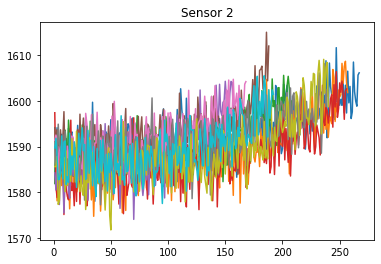

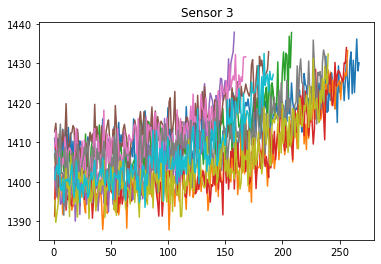

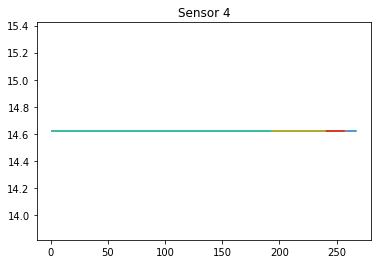

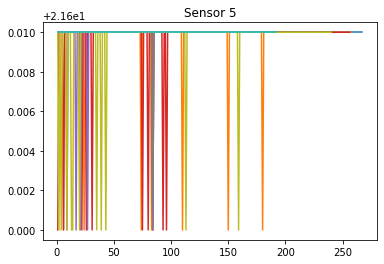

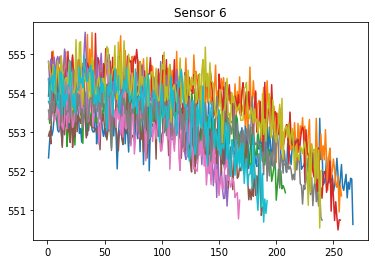

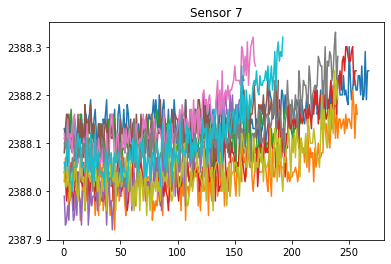

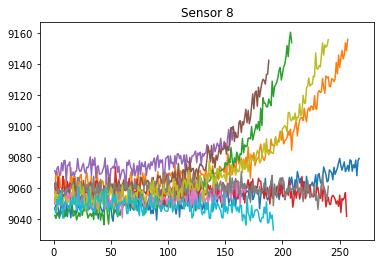

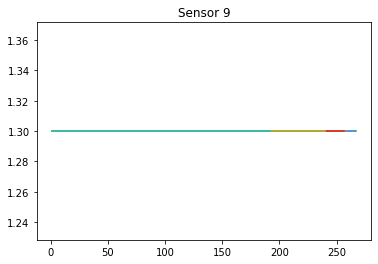

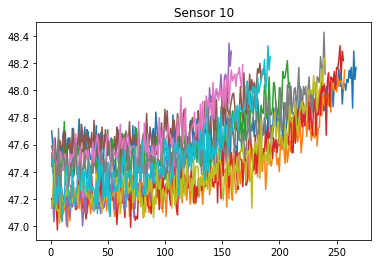

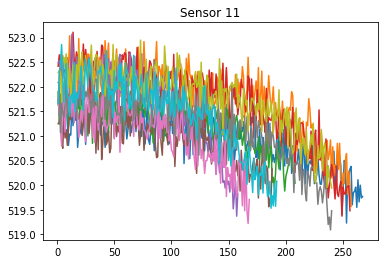

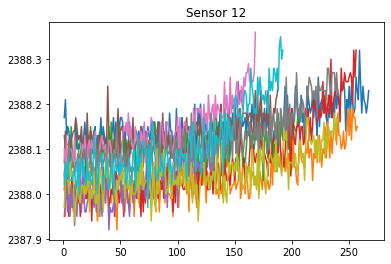

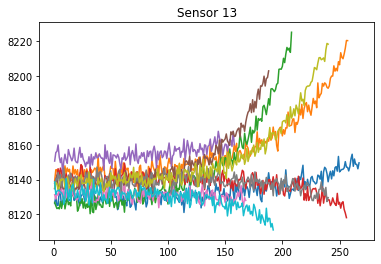

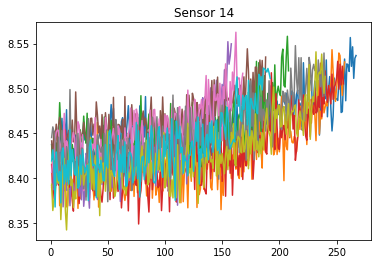

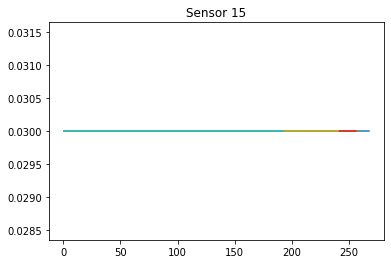

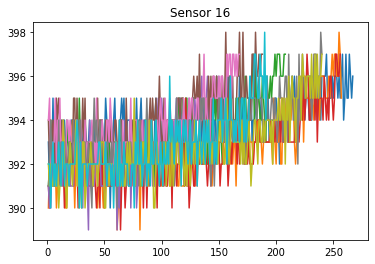

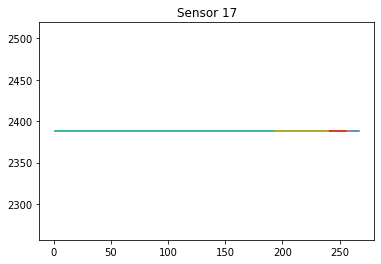

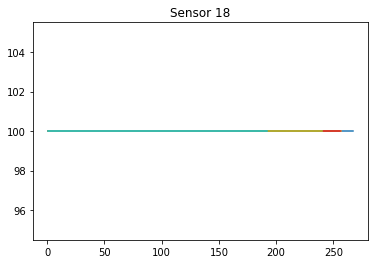

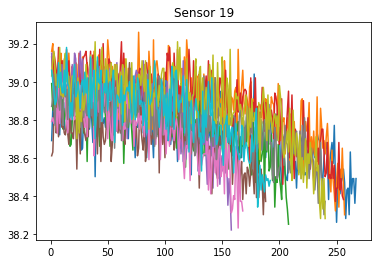

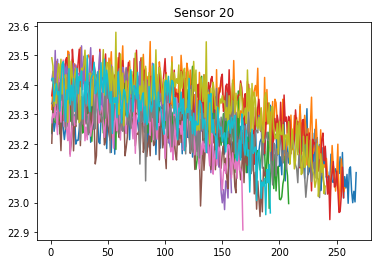

In [20]:
for i in range(1,21):
    plot_sensor_i(i)
    plt.show()

# LinearRegression

In [25]:
y_train = train['RUL']
y_train.head()

0    191
1    190
2    189
3    188
4    187
Name: RUL, dtype: int64

In [27]:
X_train = train
X_train = X_train.drop(index_cols+settings_cols+['RUL'], axis=1)
X_train.head()

,s_0,s_1,s_2,s_3,s_4,s_5,s_6,s_7,s_8,s_9,...,s_11,s_12,s_13,s_14,s_15,s_16,s_17,s_18,s_19,s_20
0,518.67,641.82,1589.70,1400.60,14.62,21.61,554.36,2388.06,9046.19,1.3,...,521.66,2388.02,8138.62,8.4195,0.03,392,2388,100.0,39.06,23.4190
1,518.67,642.15,1591.82,1403.14,14.62,21.61,553.75,2388.04,9044.07,1.3,...,522.28,2388.07,8131.49,8.4318,0.03,392,2388,100.0,39.00,23.4236
2,518.67,642.35,1587.99,1404.20,14.62,21.61,554.26,2388.08,9052.94,1.3,...,522.42,2388.03,8133.23,8.4178,0.03,390,2388,100.0,38.95,23.3442
3,518.67,642.35,1582.79,1401.87,14.62,21.61,554.45,2388.11,9049.48,1.3,...,522.86,2388.08,8133.83,8.3682,0.03,392,2388,100.0,38.88,23.3739
4,518.67,642.37,1582.85,1406.22,14.62,21.61,554.00,2388.06,9055.15,1.3,...,522.19,2388.04,8133.80,8.4294,0.03,393,2388,100.0,38.90,23.4044


In [28]:
from sklearn.linear_model import LinearRegression

model = LinearRegression()
model.fit(X_train, y_train)

LinearRegression()

In [29]:
model.score(X_train,y_train)

0.5795500450752367

In [32]:
from sklearn.metrics import mean_squared_error

def rmse(y_true, y_pred):
    mse = mean_squared_error(y_pred, y_true)
    return np.sqrt(mse)

In [33]:
rmse(y_train, model.predict(X_train))

44.662806660265915

In [34]:
from sklearn.metrics import r2_score

r2_score(y_train, model.predict(X_train))

0.5795500450752367

## Non-linear decay

In [40]:
y_non_linear = y_train.clip(upper=50)
y_non_linear.head()

0    50
1    50
2    50
3    50
4    50
Name: RUL, dtype: int64

In [42]:
k = 50
y_non_linear = y_train.clip(upper=k)
model = LinearRegression()
model.fit(X_train, y_non_linear)
model.score(X_train, y_non_linear)

0.6752143992259676

In [45]:
myrange = [10,50,100,150,200]

for k in myrange:
    y_non_linear = y_train.clip(upper=k)
    model = LinearRegression()
    model.fit(X_train, y_non_linear)
    sc = model.score(X_train, y_non_linear)
    print(f"{k}:{sc:.2f}")

10:0.25
50:0.68
100:0.76
150:0.70
200:0.64


In [47]:
myrange = np.arange(50,150,10)

for k in myrange:
    y_non_linear = y_train.clip(upper=k)
    model = LinearRegression()
    model.fit(X_train, y_non_linear)
    sc = model.score(X_train, y_non_linear)
    print(f"{k}:{sc:.2f}")

50:0.68
60:0.71
70:0.74
80:0.75
90:0.76
100:0.76
110:0.75
120:0.74
130:0.73
140:0.72


In [49]:
myrange = np.arange(80,110,5)

for k in myrange:
    y_non_linear = y_train.clip(upper=k)
    model = LinearRegression()
    model.fit(X_train, y_non_linear)
    sc = model.score(X_train, y_non_linear)
    print(f"{k}:{sc:.3f}")

80:0.753
85:0.756
90:0.758
95:0.757
100:0.756
105:0.753


In [50]:
k = 90
y_non_linear = y_train.clip(upper=k)
model = LinearRegression()
model.fit(X_train, y_non_linear)
model.score(X_train, y_non_linear)

0.7575177725059666

In [51]:
rmse(y_non_linear,model.predict(X_train))

13.958909540102844

# Feature Extraction